In [1]:
# NAME: loader.py
# DESCRIPTION: data loader for raw kitti data

import os
import sys
# sys.path.append('/home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/deepSfm_ori/FME')

import numpy as np 
import scipy.misc
import os
import cv2
from glob import glob

from path import Path
from tqdm import tqdm
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from torch.utils.data import Dataset

# for test
# from config import get_config
# config, unparsed = get_config()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import argparse
from pebble import ProcessPool


# Dump

> python dump_img.py --dump --with_X --with_pose --with_sift --static_frames_file /home/ruizhu/Documents/Projects/SfmLearner-Pytorch/data/static_frames.txt --test_scene_file /home/ruizhu/Documents/Projects/SfmLearner-Pytorch/data/test_scenes.txt --dataset_dir /newfoundland/kitti_raw/ --dump_root /home/ruizhu/Documents/Datasets/kitti/corr_dump2

In [123]:
parser = argparse.ArgumentParser(description='Foo')
parser.add_argument("--dataset_dir", type=str, default="/data/KITTI/raw_meta/", help="path to dataset")   
parser.add_argument("--num_threads", type=int, default=1, help="number of thread to load data")
parser.add_argument("--img_height", type=int, default=128, help="number of thread to load data")
parser.add_argument("--img_width", type=int, default=416, help="number of thread to load data")
parser.add_argument("--static_frames_file", type=str, default="ref/static_frames.txt", help="static data file path")
parser.add_argument("--test_scene_file", type=str, default="ref/test_scenes_eigen.txt", help="test data file path")
parser.add_argument('--dump', action='store_true', default=False)
parser.add_argument("--with_X", action='store_true', default=False,
                    help="If available (e.g. with KITTI), will store visable rectified lidar points ground truth along with images, for validation")
parser.add_argument("--with_pose", action='store_true', default=True,
                    help="If available (e.g. with KITTI), will store pose ground truth along with images, for validation")
parser.add_argument("--with_sift", action='store_true', default=False,
                    help="If available (e.g. with KITTI), will store SIFT points ground truth along with images, for validation")
parser.add_argument("--dump_root", type=str, default='dump', help="Where to dump the data")

args = parser.parse_args('--dump --with_X --with_pose --with_sift \
    --static_frames_file /home/ruizhu/Documents/Projects/SfmLearner-Pytorch/data/static_frames.txt \
    --test_scene_file /home/ruizhu/Documents/Projects/SfmLearner-Pytorch/data/test_scenes.txt \
    --dataset_dir /home/ruizhu/Documents/Datasets/kitti/raw \
    --dump_root /home/ruizhu/Documents/Datasets/kitti/corr_dump'.split())
print(args)

%reload_ext autoreload
%autoreload 2
from kitti_raw_loader import KittiRawLoader

data_loader = KittiRawLoader(args.dataset_dir,
                             static_frames_file=args.static_frames_file,
                             test_scene_file=args.test_scene_file,
                             img_height=args.img_height,
                             img_width=args.img_width,
                             get_X=args.with_X,
                             get_pose=args.with_pose,
                             get_sift=args.with_sift)

drive_path_test = data_loader.get_drive_path('2011_09_26', '0005')
data_loader.scenes = [drive_path_test]

n_scenes = len(data_loader.scenes)
print('Found {} potential scenes'.format(n_scenes))

args_dump_root = Path(args.dump_root)
args_dump_root.mkdir_p()

print('== Retrieving frames')
def dump_scenes_from_drive(args, drive_path):
    scene_list = data_loader.collect_scenes(drive_path)
    data_loader.dump_drive(args, drive_path, scene_list)
    return scene_list

if args.num_threads == 1:
    for drive_path in tqdm (data_loader.scenes):
        scene_list = dump_scenes_from_drive(args, drive_path)
else:
    with ProcessPool(max_workers=args.num_threads) as pool:
        tasks = pool.map(dump_scenes_from_drive, [args]*n_scenes, data_loader.scenes)
        try:
            for _ in tqdm(tasks.result(), total=n_scenes):
                pass
        except KeyboardInterrupt as e:
            tasks.cancel()
            raise e
    
print('== Generating train val lists')
np.random.seed(8964)
val_ratio = 0.0
# to avoid data snooping, we will make two cameras of the same scene to fall in the same set, train or val
subdirs = args_dump_root.dirs() # e.g. Path('./data/kitti_dump/2011_09_30_drive_0034_sync_02')
canonic_prefixes = set([subdir.basename()[:-2] for subdir in subdirs]) # e.g. '2011_09_28_drive_0039_sync_'
with open(args_dump_root / 'train.txt', 'w') as tf:
    with open(args_dump_root / 'val.txt', 'w') as vf:
        for pr in tqdm(canonic_prefixes):
            corresponding_dirs = args_dump_root.dirs('{}*'.format(pr)) # e.g. [Path('./data/kitti_dump/2011_09_30_drive_0033_sync_03'), Path('./data/kitti_dump/2011_09_30_drive_0033_sync_02')]
            if np.random.random() < val_ratio:
                for s in corresponding_dirs:
                    vf.write('{}\n'.format(s.name))
            else:
                for s in corresponding_dirs:
                    tf.write('{}\n'.format(s.name))

Namespace(dataset_dir='/home/ruizhu/Documents/Datasets/kitti/raw', dump=True, dump_root='/home/ruizhu/Documents/Datasets/kitti/corr_dump', img_height=128, img_width=416, num_threads=1, seed=0, static_frames_file='/home/ruizhu/Documents/Projects/SfmLearner-Pytorch/data/static_frames.txt', test_scene_file='/home/ruizhu/Documents/Projects/SfmLearner-Pytorch/data/test_scenes.txt', with_X=True, with_pose=True, with_sift=True)


# Sequence read

In [136]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

parser = argparse.ArgumentParser(description='Foo')
parser.add_argument("--dump-root", type=str, default='dump', help="Where to dump the data")
parser.add_argument('--sequence-length', type=int, metavar='N', help='sequence length for training', default=2)
parser.add_argument('--delta_ij', type=int, metavar='N', help='increments (e.g. [0, 2, 4], delta_ij=2)', default=1)
parser.add_argument('-b', '--batch-size', default=1, type=int, metavar='N', 
                    help='mini-batch size')
parser.add_argument('--epoch-size', default=0, type=int, metavar='N',
                    help='manual epoch size (will match dataset size if not set)')
parser.add_argument('--epochs', default=1, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument("--with_X", action='store_true', default=False,
                    help="If available (e.g. with KITTI), will store visable rectified lidar points ground truth along with images, for validation")
parser.add_argument("--with_pose", action='store_true', default=False,
                    help="If available (e.g. with KITTI), will store pose ground truth along with images, for validation")
parser.add_argument("--with_sift", action='store_true', default=False,
                    help="If available (e.g. with KITTI), will store SIFT points ground truth along with images, for validation")
parser.add_argument('--seed', default=0, type=int, help='seed for random functions, and network initialization')
parser.add_argument('-j', '--workers', default=12, type=int, metavar='N', 
                    help='number of data loading workers')

args = parser.parse_args('--with_X --with_pose --with_sift --dump-root /home/ruizhu/Documents/Datasets/kitti/corr_dump2 --sequence-length 2 --delta_ij 10'.split())
print(args)

best_error = -1
n_iter = 0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

from sequence_folders import SequenceLoader

train_set = SequenceLoader(
        args.dump_root,
        transform=None,
        seed=args.seed,
        train=True,
        sequence_length=args.sequence_length,
        delta_ij=args.delta_ij,
        get_X=args.with_X,
        get_pose=args.with_pose,
        get_sift=args.with_sift
)
np.set_printoptions(precision=8, suppress=True)
print('{} samples found in {} train scenes'.format(len(train_set), len(train_set.scenes)))
# imgs, intrinsics, scene_name, frame_ids, Xs, sift_kps, sift_deses, scene_poses = train_set.__getitem__(0)
# print(scene_name, frame_ids, len(imgs))


train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)
if args.epoch_size == 0:
    args.epoch_size = len(train_loader) # len(scenes)//batch_size

def train_one_epoch(args, train_loader, epoch_size):
    global n_iter, device

    for i, (imgs, intrinsics, scene_name, frame_ids, Xs, sift_kps, sift_deses, scene_poses) in tqdm(enumerate(train_loader)):
        imgs = [img.to(device) for img in imgs]
#         intrinsics = intrinsics.to(device)
#         frame_ids = [frame_id.to(device) for frame_id in frame_ids]
        if args.with_X:
            Xs = [X.to(device) for X in Xs]
        if args.with_sift:
            sift_kps = [sift_kp.to(device) for sift_kp in sift_kps]
            sift_deses = [sift_des.to(device) for sift_des in sift_deses]
        if args.with_pose:
            scene_poses = [scene_pose.to(device) for scene_pose in scene_poses]
        
for epoch in range(args.epochs):
    train_loss = train_one_epoch(args, train_loader, args.epoch_size)

Namespace(batch_size=1, delta_ij=10, dump_root='/home/ruizhu/Documents/Datasets/kitti/corr_dump2', epoch_size=0, epochs=1, seed=0, sequence_length=2, with_X=True, with_pose=True, with_sift=True, workers=12)
cuda
1995 samples found in 8 train scenes




0it [00:00, ?it/s]

1it [00:00,  4.52it/s]

13it [00:00,  6.34it/s]

27it [00:00,  8.88it/s]

34it [00:00, 12.01it/s]

44it [00:00, 16.31it/s]

52it [00:00, 21.26it/s]

64it [00:00, 27.64it/s]

76it [00:00, 35.68it/s]

86it [00:01, 43.91it/s]

96it [00:01, 51.54it/s]

105it [00:01, 57.23it/s]

114it [00:01, 63.60it/s]

123it [00:01, 67.62it/s]

133it [00:01, 69.99it/s]

145it [00:01, 78.87it/s]

155it [00:01, 80.94it/s]

165it [00:02, 83.61it/s]

174it [00:02, 82.34it/s]

184it [00:02, 83.27it/s]

195it [00:02, 89.55it/s]

205it [00:02, 89.10it/s]

215it [00:02, 89.87it/s]

225it [00:02, 82.19it/s]

235it [00:02, 86.03it/s]

244it [00:02, 87.13it/s]

255it [00:03, 90.08it/s]

265it [00:03, 91.30it/s]

275it [00:03, 88.68it/s]

285it [00:03, 90.24it/s]

295it [00:03, 86.61it/s]

304it [00:03, 83.39it/s]

313it [00:03, 81.00it/s]

322it [00:03, 82.28it/s]

331it [00:03, 82.44it/s]

340it [00:04, 84.25it/s]

350it [00:04, 85.00it/s]

361it [00:04, 89.64it/s]

371it [00:04, 89.99it/s]

3

KeyboardInterrupt: 

Exception in thread Thread-24:
Traceback (most recent call last):
  File "/home/ruizhu/anaconda3/envs/kitti_py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ruizhu/anaconda3/envs/kitti_py36/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ruizhu/anaconda3/envs/kitti_py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 158, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/ruizhu/anaconda3/envs/kitti_py36/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/ruizhu/anaconda3/envs/kitti_py36/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 256, in rebuild_storage_fd
    fd = df.detach()
  File "/home/ruizhu/anaconda3/envs/kitti_py36/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as 

2011_09_26_drive_0035_sync_02 [27, 37] 2
Reading from input list of param_list=[K, im_shape].


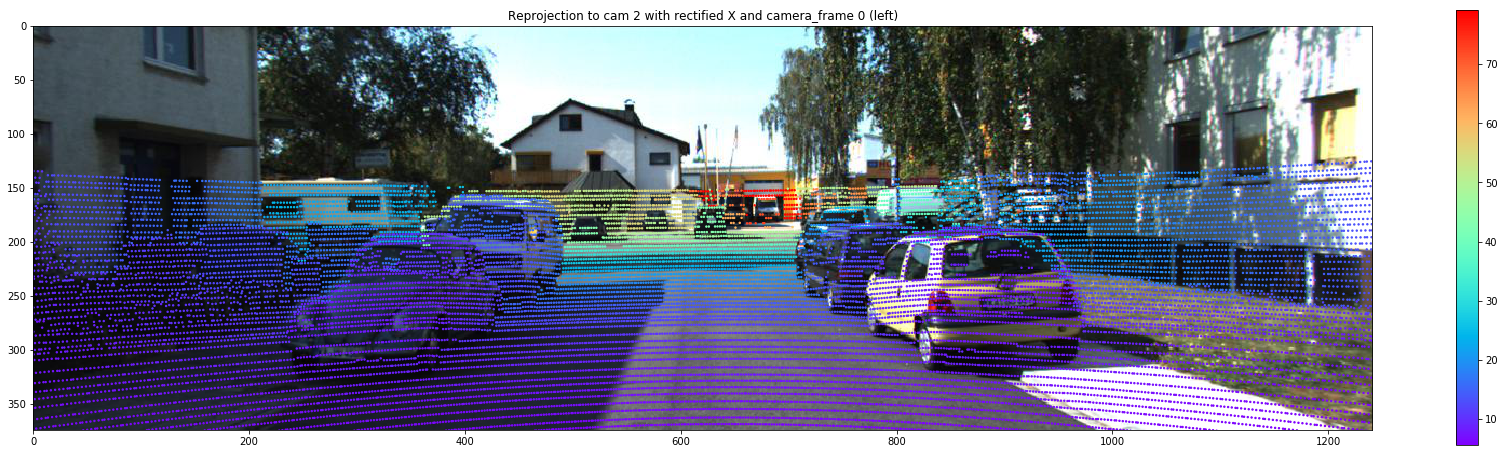

Reading from input list of param_list=[K, im_shape].


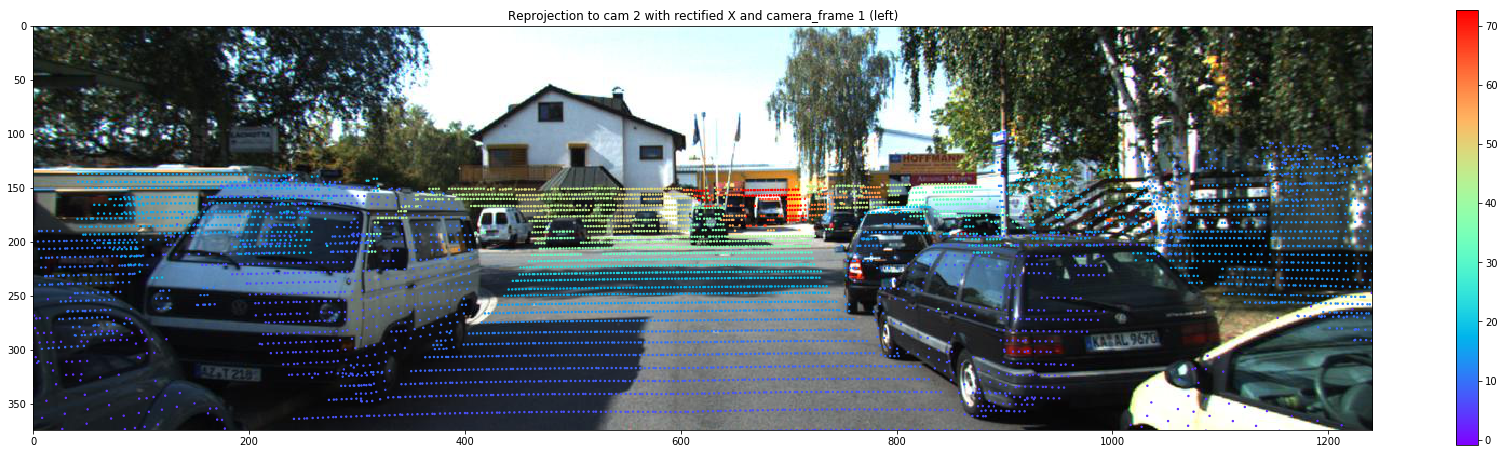



441it [00:21, 87.84it/s]

In [137]:
imgs, intrinsics, scene_name, frame_ids, Xs, sift_kps, sift_deses, scene_poses = train_set.__getitem__(15)
print(scene_name, frame_ids, len(imgs))
import sys
sys.path.append("/home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils")
sys.path.append("/home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/dsac_tools")
import utils_vis, utils_misc
delta_Rtij = utils_misc.Rt_depad(scene_poses[-1]) # scene motion
val_inds_i = utils_vis.reproj_and_scatter(utils_misc.identity_Rt(), Xs[0], imgs[0].astype(np.uint8), visualize=True, title_appendix='frame %d (left)'%0, param_list = [intrinsics, imgs[0].shape[:2]])
val_inds_j = utils_vis.reproj_and_scatter(delta_Rtij, Xs[0], imgs[-1].astype(np.uint8), visualize=True, title_appendix='frame %d (left)'%1, param_list = [intrinsics, imgs[0].shape[:2]])

In [98]:
np.set_printoptions(precision=4, suppress=True)
print(scene_poses[-1])

[[ 1.     -0.001  -0.002  -0.5182]
 [ 0.001   1.     -0.0079  0.0089]
 [ 0.002   0.0079  1.     -1.8198]
 [ 0.      0.      0.      1.    ]]


In [45]:
length = 10
sequence_length = 10
start_i = 0
delta_ij = 1
# print([idx*delta_ij+start_i for idx in range(sequence_length)])
max_idx = (sequence_length-1)*delta_ij
print(max_idx)

if  length <= max_idx:
    print('---', length, (sequence_length-1)*delta_ij)
    
for start_i in range(length - max_idx):
    print([idx*delta_ij+start_i for idx in range(sequence_length)])
    print(start_i)
    for delta_j in range(1, sequence_length):
            print(start_i+delta_j*delta_ij)


9
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
0
1
2
3
4
5
6
7
8
9


In [8]:
print(scene_poses[1])

-1


[2.91960788 2.47282767] [1237.02233887  363.6321106 ]


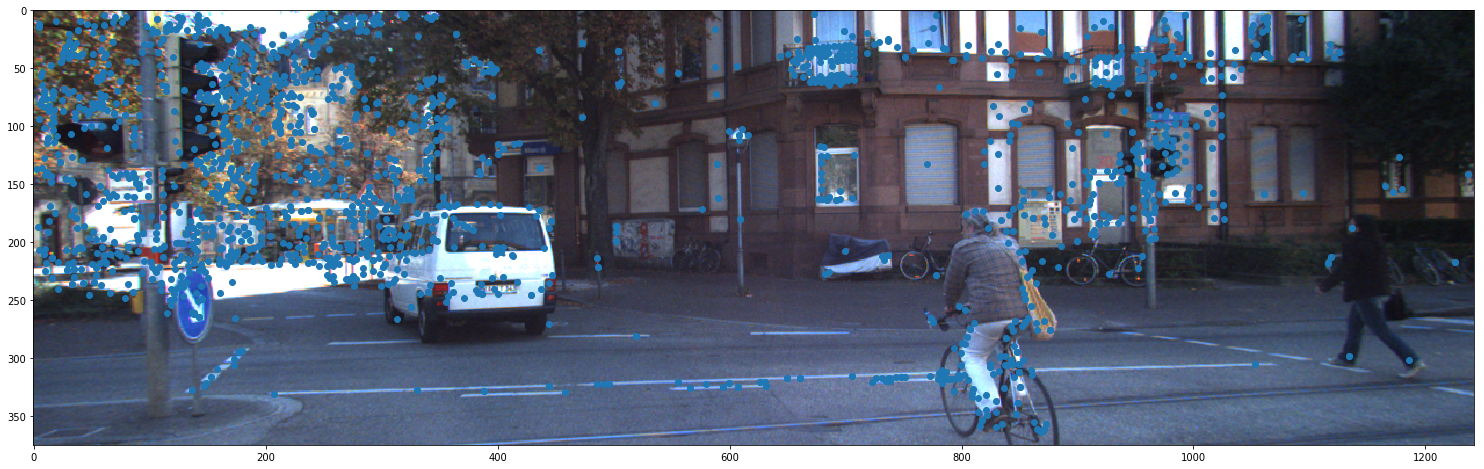

[-1.09992824 -1.09610513] [ 0.61045048 -0.59556401]


In [105]:
x = scene_list[0]['X_rect'][0]
xy = scene_list[0]['sift_kp'][0]
print(np.min(xy, 0), np.max(xy, 0))
im = scene_list[0]['img_l'][0]
K =  scene_list[0]['K']

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 8))
plt.imshow(im)
plt.scatter(xy[:, 0], xy[:, 1])
plt.show()

cx = (im.size[1] - 1.0) * 0.5
cy = (im.size[0] - 1.0) * 0.5
# Correct coordinates using K
cx += K[0, 2]
cy += K[1, 2]
# xy = np.array([_kp.pt for _kp in cv_kp])
# Correct focals
fx = K[0, 0]
fy = K[1, 1]
kp = (
    xy - np.array([[cx, cy]])
) / np.asarray([[fx, fy]])

print(np.min(kp, 0), np.max(kp, 0))

In [114]:
from dsac_tools.utils_misc import *
xy2 = de_homo_np((np.linalg.inv(K) @ homo_np(xy).T).T)
print(np.min(xy2, 0), np.max(xy2, 0))

[-0.84075952 -0.2361362 ] [0.8696192  0.26440491]


In [115]:
K

array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.854 ],
       [  0.    ,   0.    ,   1.    ]])

In [100]:
print(kp.shape)

(2000, 2)


In [92]:
im.size[1]

375

In [87]:
 scene_list[0]['K']

array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.854 ],
       [  0.    ,   0.    ,   1.    ]])

In [ ]:
import matplotlib.pyplot as plt
